In [1]:
# EcoVision MobileNetV3 Garbage Classification
# Jupyter Notebook Version

# Cell 1: Import libraries and setup
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_large
from PIL import Image
import matplotlib.pyplot as plt
import json
import os

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.4.1+cpu
CUDA available: False


In [ ]:
# Cell 2: Define the classifier class (simplified version)
class EcoVisionClassifier:
    def __init__(self, model_path="pytorch_model.bin"):
        self.class_labels = [
            'battery', 'biological', 'cardboard', 'clothes', 'glass',
            'metal', 'paper', 'plastic', 'shoes', 'trash'
        ]
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._load_model(model_path)
        self.model.to(self.device)
        print(f"Model loaded on {self.device}")
    
    def _load_model(self, model_path):
        model = mobilenet_v3_large(pretrained=False)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[0].in_features, 1280),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(1280, len(self.class_labels))
        )
        
        # Try to load weights
        for path in [model_path, "ecovision_mobilenetv3_ST.pth"]:
            if os.path.exists(path):
                try:
                    state_dict = torch.load(path, map_location='cpu')
                    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
                        model.load_state_dict(state_dict['model_state_dict'])
                    else:
                        model.load_state_dict(state_dict)
                    print(f"Weights loaded from {path}")
                    break
                except Exception as e:
                    print(f"Failed to load {path}: {e}")
        
        model.eval()
        return model
    
    def predict(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            predicted_idx = torch.argmax(probabilities).item()
            
        return {
            'class': self.class_labels[predicted_idx],
            'confidence': probabilities[predicted_idx].item(),
            'all_probs': {self.class_labels[i]: probabilities[i].item() 
                         for i in range(len(self.class_labels))}
        }
    
    def visualize_prediction(self, image_path):
        # Load and display image
        image = Image.open(image_path)
        
        # Make prediction
        result = self.predict(image_path)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Display image
        ax1.imshow(image)
        ax1.set_title(f"Input Image\nPredicted: {result['class']}\nConfidence: {result['confidence']:.3f}")
        ax1.axis('off')
        
        # Display probabilities
        classes = list(result['all_probs'].keys())
        probs = list(result['all_probs'].values())
        
        bars = ax2.barh(classes, probs)
        ax2.set_xlabel('Probability')
        ax2.set_title('Class Probabilities')
        ax2.set_xlim(0, 1)
        
        # Highlight predicted class
        max_idx = probs.index(max(probs))
        bars[max_idx].set_color('red')
        
        plt.tight_layout()
        plt.show()
        
        return result

In [3]:
# Cell 3: Initialize the classifier
classifier = EcoVisionClassifier()

Weights loaded from pytorch_model.bin
Model loaded on cpu


c:\Users\Lejlum\miniconda3\envs\pa2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lejlum\miniconda3\envs\pa2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Lejlum\AppData\Local\Temp\ipykernel_14464\3687591060.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weig

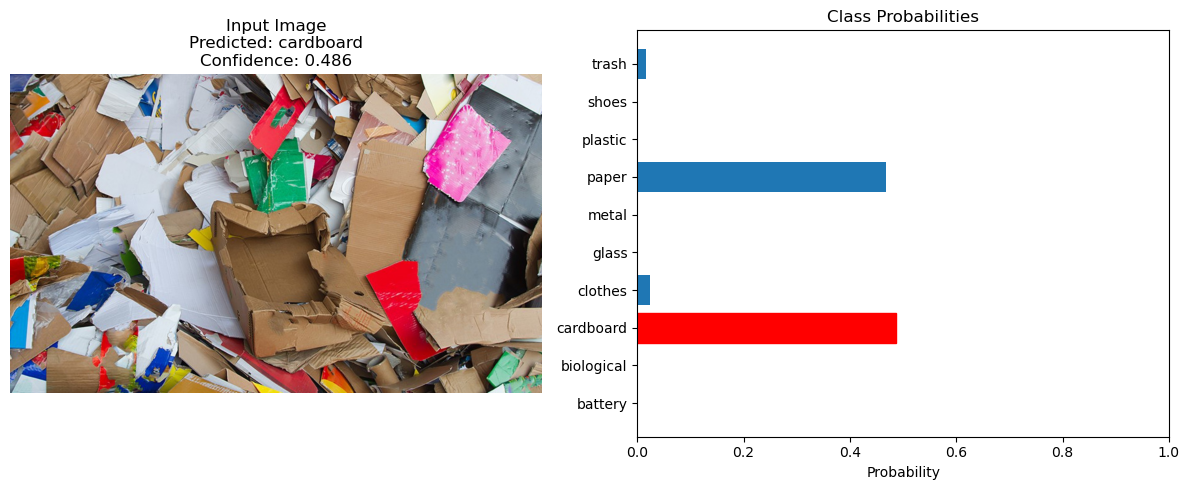


Detailed Results:
Predicted Class: cardboard
Confidence: 0.4860


In [4]:
# Cell 4: Example usage - Single image prediction
# Replace 'your_image.jpg' with the path to your test image
image_path = "carton_test.jpg"

if os.path.exists(image_path):
    result = classifier.visualize_prediction(image_path)
    print(f"\nDetailed Results:")
    print(f"Predicted Class: {result['class']}")
    print(f"Confidence: {result['confidence']:.4f}")
else:
    print(f"Image not found: {image_path}")
    print("Please update the image_path variable with a valid image file.")


In [ ]:
# Cell 5: Batch prediction function
def predict_multiple_images(image_folder="./Image"):
    """Predict on multiple images from a folder"""
    if not os.path.exists(image_folder):
        print(f"Folder {image_folder} not found")
        return
    
    results = []
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(image_folder, filename)
            try:
                result = classifier.predict(image_path)
                result['filename'] = filename
                results.append(result)
                print(f"{filename}: {result['class']} ({result['confidence']:.3f})")
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    
    return results

In [6]:
# Cell 6: Run batch prediction (uncomment to use)
batch_results = predict_multiple_images()

batt1.png: battery (1.000)
batt2.png: cardboard (0.840)
biologi1.png: biological (1.000)
biologi2.png: shoes (0.580)
cardboard1.png: cardboard (1.000)
cardboard2.png: paper (0.724)
cloth1.png: clothes (1.000)
cloth2.png: paper (0.911)
glass1.png: glass (1.000)
glass2.png: glass (0.329)
Gradio_Exemple.png: battery (0.773)
metal1.png: metal (1.000)
metal2.png: cardboard (0.421)
paper1.png: paper (1.000)
paper2.png: paper (0.965)
plastic1.png: plastic (1.000)
plastic2.png: plastic (0.364)
shoes1.png: shoes (1.000)
shoes2.png: cardboard (0.687)
trash1.png: trash (1.000)
trash2.png: trash (0.654)


In [7]:
# Cell 7: Interactive prediction function
def interactive_prediction():
    """Interactive function to test different images"""
    while True:
        image_path = input("\nEnter image path (or 'quit' to exit): ")
        if image_path.lower() == 'quit':
            break
        
        if os.path.exists(image_path):
            try:
                result = classifier.visualize_prediction(image_path)
                print(f"Prediction: {result['class']} (confidence: {result['confidence']:.3f})")
            except Exception as e:
                print(f"Error: {e}")
        else:
            print("File not found. Please check the path.")

In [8]:
# Cell 8: Model info and available classes
print("EcoVision MobileNetV3 Model Information:")
print("=" * 50)
print(f"Number of classes: {len(classifier.class_labels)}")
print(f"Classes: {', '.join(classifier.class_labels)}")
print(f"Model device: {classifier.device}")
print(f"Input size: 224x224 RGB")
print("\nTo use:")
print("1. Update image_path in Cell 4 with your image")
print("2. Run classifier.visualize_prediction('your_image.jpg')")
print("3. Use interactive_prediction() for multiple tests")

EcoVision MobileNetV3 Model Information:
Number of classes: 10
Classes: battery, biological, cardboard, clothes, glass, metal, paper, plastic, shoes, trash
Model device: cpu
Input size: 224x224 RGB

To use:
1. Update image_path in Cell 4 with your image
2. Run classifier.visualize_prediction('your_image.jpg')
3. Use interactive_prediction() for multiple tests


In [9]:
# Cell 9: Test with sample images (if available)
# Uncomment and modify as needed
"""
sample_images = [
    "sample_battery.jpg",
    "sample_plastic.jpg", 
    "sample_cardboard.jpg"
]

for img in sample_images:
    if os.path.exists(img):
        print(f"\nTesting {img}:")
        result = classifier.predict(img)
        print(f"Prediction: {result['class']} ({result['confidence']:.3f})")
"""

'\nsample_images = [\n    "sample_battery.jpg",\n    "sample_plastic.jpg", \n    "sample_cardboard.jpg"\n]\n\nfor img in sample_images:\n    if os.path.exists(img):\n        print(f"\nTesting {img}:")\n        result = classifier.predict(img)\n        print(f"Prediction: {result[\'class\']} ({result[\'confidence\']:.3f})")\n'